In [1]:
import numpy as np
import time
import zhinst.core as zc
import zhinst.utils as zu
import matplotlib.pyplot as plts
from zhinst.toolkit import Session, CommandTable
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np

In [5]:
device_id='dev1263'
server_host ='127.0.0.1'
## connect to data server
session = Session(server_host,hf2=True)
## connect to device
hf2li = session.connect_device(device_id)
print(hf2li)

BaseInstrument(HF2LI(PLL,MOD,PID),dev1263)


In [7]:
#define initial parameters
amplitude=0.1
rangeamp=1
out_channel = 0
out_mixer_channel = 6
in_channel = 0
demod_index = 0
osc_index = 0
demod_rate = 10e3
time_constant = 0.01
filterorder=4
frequency=110e3


with hf2li.set_transaction():
    hf2li.sigins[0].ac(0)
    hf2li.sigins[0].range(1)
    hf2li.demods[0].enable(1)
    hf2li.demods[0].rate(demod_rate)
    hf2li.demods[0].adcselect(0)
    hf2li.demods[0].order(filterorder)
    hf2li.demods[0].timeconstant(time_constant)
    hf2li.demods[0].oscselect(osc_index)
    hf2li.demods[0].harmonic(1)
    hf2li.sigouts[out_channel].on(1)
    hf2li.sigouts[out_channel].enables[out_mixer_channel](1)
    hf2li.sigouts[out_channel].range(rangeamp)
    hf2li.sigouts[out_channel].amplitudes[out_mixer_channel](amplitude)
    hf2li.oscs[0].freq(frequency)
    hf2li.system.extclk(0)

In [8]:
#set sweep parameters
startfreq=1e3
stopfreq=10e3
samplecount=10
tc=10
loopcount=1
avg=1

#Creating instance of sweeper module
sweeper=session.modules.sweeper
sweeper.device(hf2li)


sweeper.gridnode(hf2li.oscs[osc_index].freq)
sweeper.gridnode(hf2li.oscs[osc_index].freq)
sweeper.start(startfreq)
sweeper.stop(stopfreq) # 500e3 for MF devices, 50e6 for others
sweeper.samplecount(samplecount)
sweeper.xmapping(0)
sweeper.bandwidthcontrol(2)
sweeper.bandwidthoverlap(0)
sweeper.scan(0)
sweeper.loopcount(loopcount)
sweeper.settling.time(0)
sweeper.settling.inaccuracy(0.001)
sweeper.averaging.tc(tc)
sweeper.averaging.sample(samplecount)



In [9]:
sample_node = hf2li.demods[demod_index].sample
sweeper.subscribe(sample_node)

In [10]:
sweeper.save.fileformat.node_info.options

{0: _option_info(enum='mat', description='MATLAB'),
 1: _option_info(enum='csv', description='CSV'),
 2: _option_info(enum='zview', description='ZView (Impedance data only)'),
 3: _option_info(enum='sxm', description='SXM (Image format)'),
 4: _option_info(enum='hdf5', description='HDF5')}

In [11]:
sweeper.save.filename('sweep_with_save')
sweeper.save.fileformat('mat')

In [12]:
handler = logging.StreamHandler(sys.stdout)
logging.getLogger("zhinst.toolkit").setLevel(logging.INFO)
logging.getLogger("zhinst.toolkit").addHandler(handler)

sweeper.execute()
print(f"Perform {loopcount} sweeps")
sweeper.wait_done(timeout=300)

Perform 1 sweeps
Progress: 0.0%
Progress: 100.0%


In [13]:
sweeper.save.save(True)
# Wait until the save is complete. The saving is done asynchronously in the background
# so we need to wait until it is complete. In the case of the sweeper it is important
# to wait for completion before before performing the module read command. The sweeper has
# a special fast read command which could otherwise be executed before the saving has
# started.
sweeper.save.save.wait_for_state_change(True, invert=True, timeout=5)

In [14]:
# Save the data as variable and without saving directly
data = sweeper.read()
sweeper.unsubscribe(sample_node)

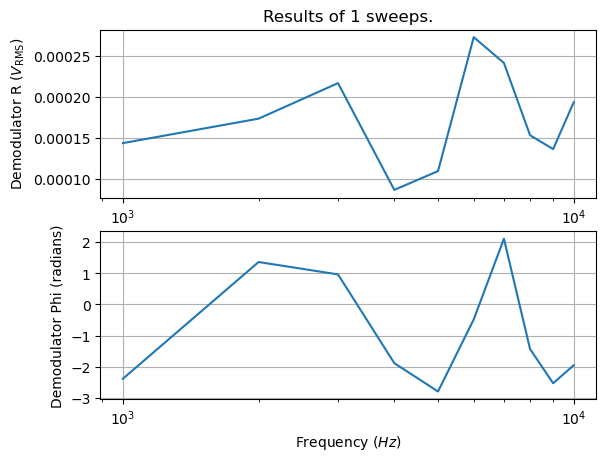

In [15]:


node_samples = data[sample_node]

_, (ax1, ax2) = plt.subplots(2, 1)
for sample in node_samples:
    frequency = sample[0]["frequency"]
    demod_r = np.abs(sample[0]["x"] + 1j * sample[0]["y"])
    phi = np.angle(sample[0]["x"] + 1j * sample[0]["y"])
    ax1.plot(frequency, demod_r)
    ax2.plot(frequency, phi)
ax1.set_title(f"Results of {len(node_samples)} sweeps.")
ax1.grid()
ax1.set_ylabel(r"Demodulator R ($V_\mathrm{RMS}$)")
ax1.set_xscale("log")
ax2.autoscale()

ax2.grid()
ax2.set_xlabel("Frequency ($Hz$)")
ax2.set_ylabel(r"Demodulator Phi (radians)")
ax2.set_xscale("log")
ax2.autoscale()

plt.draw()
plt.show()